In [3]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio 
from IPython.core.display import display
import pandas as pd

C:\Users\trick\AppData\Local\Temp\ipykernel_12944\3081543886.py:7: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


Split the dataset into training and testing sets

In [4]:
labels = {'angry': 0, 'fear': 1, 'happy': 2, 'sad': 3}

In [5]:
X = np.array([])
for folder in os.listdir('./data'):
    for file in os.listdir(f"./data/{folder}"):
        X = np.append(X, f"data/{folder}/{file}")
y = np.array([0]*100 + [1]*100 + [2]*100 + [3]*100)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

Exploratory Data Analysis

In [7]:
max_length = 0
for x in X:
    signal = librosa.load(x)[0]
    if len(signal) > max_length:
        max_length = len(signal)

In [8]:
rand_int = np.random.randint(3,100)
random_samples = X[rand_int::100]
random_samples[2] = X[rand_int+198]

In [9]:
for sample in random_samples:
    display(Audio(sample))

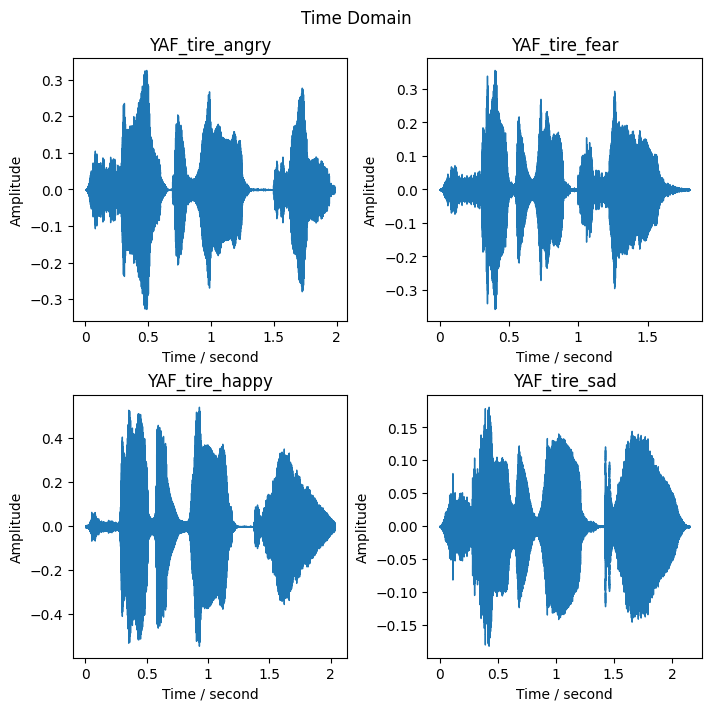

In [10]:
fig, axs = plt.subplots(2,2, constrained_layout=True, figsize=(7,7))
fig.suptitle("Time Domain")
for i,sample in enumerate(random_samples):
    signal, sample_rate = librosa.load(sample)
    if (i == 0):
        ax = axs[0,0]
    elif (i == 1):
        ax = axs[0,1]
    elif (i == 2):
        ax = axs[1,0]
    else:
        ax = axs[1,1]
    ax.set_title(sample.split('/')[2].split('.')[0])
    librosa.display.waveshow(y=signal, sr=sample_rate, ax=ax)
    ax.set_xlabel('Time / second')
    ax.set_ylabel('Amplitude')
plt.show()

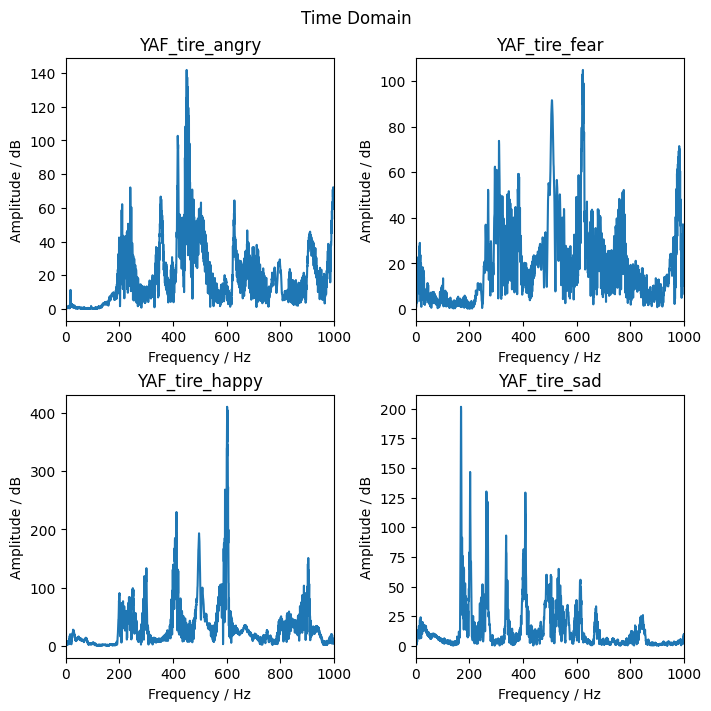

In [11]:
fig, axs = plt.subplots(2,2, constrained_layout=True, figsize=(7,7))
fig.suptitle("Time Domain")
for i,sample in enumerate(random_samples):
    signal, sample_rate = librosa.load(sample)
    if (i == 0):
        ax = axs[0,0]
    elif (i == 1):
        ax = axs[0,1]
    elif (i == 2):
        ax = axs[1,0]
    else:
        ax = axs[1,1]
    ax.set_title(sample.split('/')[2].split('.')[0])
    k = np.arange(len(signal))
    T = len(signal)/sample_rate
    freq = k/T

    DATA_0 = np.fft.fft(signal)
    abs_DATA_0 = abs(DATA_0)
    ax.plot(freq, abs_DATA_0)
    ax.set_xlim(0, 1000)
    ax.set_xlabel('Frequency / Hz')
    ax.set_ylabel('Amplitude / dB')
plt.show()

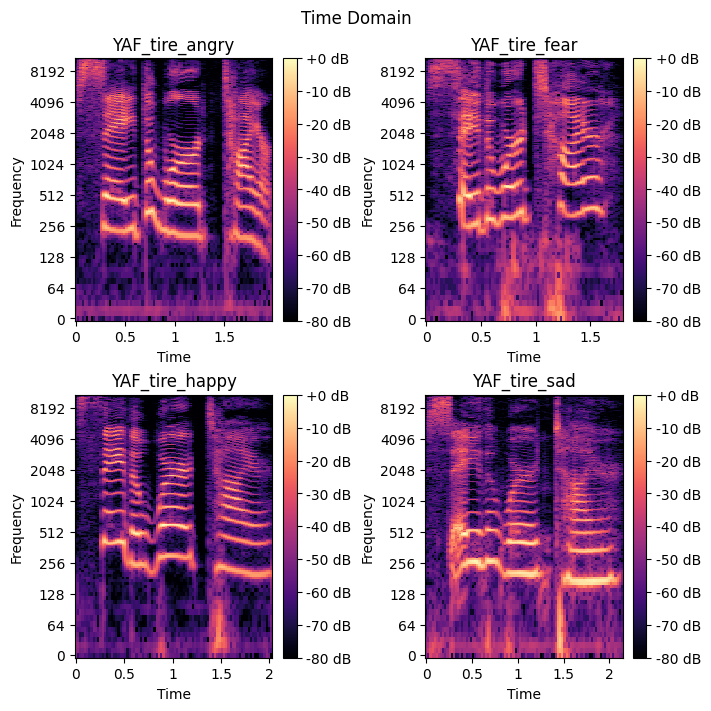

In [12]:
fig, axs = plt.subplots(2,2, constrained_layout=True, figsize=(7,7))
fig.suptitle("Time Domain")
for i,sample in enumerate(random_samples):
    signal, sample_rate = librosa.load(sample)
    if (i == 0):
        ax = axs[0,0]
    elif (i == 1):
        ax = axs[0,1]
    elif (i == 2):
        ax = axs[1,0]
    else:
        ax = axs[1,1]
    ax.set_title(sample.split('/')[2].split('.')[0])

    D = librosa.stft(signal)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    librosa.display.specshow(S_db, x_axis='time', y_axis='log')

    fig.colorbar(librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax=ax), ax=ax, format="%+2.f dB")
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
plt.show()

Acoustic Feature Extraction

In [13]:
# Time domain feature extraction (Zero-crossing Rate, root-mean-square energy)
def ExtractTimeDomainFeatures(signal):
    time_domain_df = pd.DataFrame()
    S, phase = librosa.magphase(librosa.stft(signal, win_length=25, hop_length=10))
    S.shape
    rms = librosa.feature.rms(S=S)
    time_domain_df['Loudness'] = rms[0]
    zcr = librosa.feature.zero_crossing_rate(y=signal, frame_length=25, hop_length=10)
    zcr_0 = np.pad(zcr[0], (0, len(rms[0]) - len(zcr[0])), 'constant')
    time_domain_df['ZCR'] = zcr_0
    return time_domain_df
    

In [14]:
# Time-frequency domain feature extraction (mfccs, mel-spectogram)
def ExtractTimeFrequencyDomainFeatures(signal, sample_rate):
    time_frequency_domain_df = pd.DataFrame()
    mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=12, hop_length=10, win_length=25)
    for n_mfcc in range(len(mfccs)):
        time_frequency_domain_df['MFCC_%d'%(n_mfcc+1)] = mfccs[n_mfcc]
    mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_mels=12, win_length=25, hop_length=10)
    for n_mel in range(len(mel_spectrogram)):
        time_frequency_domain_df['Mel_Spectrogram_%d'%(n_mel+1)] = mel_spectrogram[n_mel]
    return time_frequency_domain_df

Feature Post-processing

In [15]:
# Post-processing step 1: Normalize column values to range [-1,1]
def normalize(df):
    for column in df.columns:
        df[column] = ((df[column] - df[column].min()) / (df[column].max() - df[column].min())) * 2 - 1
    return df

# Post-processing step 2: Concatenate features into numpy array
def concat_features(df):
    arr = np.array([])
    for i in range(len(df)):
        arr = np.append(arr, df.iloc[i])
    return arr

# Post-processing step 3: Feature averaging
def average_features(arr, time_window, n_features):
    temp_arr_1 = arr[0:len(arr) - (len(arr) % (time_window * n_features))]
    temp_arr_2 = arr[len(arr) - (len(arr) % (time_window * n_features)):len(arr)]
    avg_arr = np.average(temp_arr_1.reshape(-1, time_window * n_features), axis=1)
    if len(temp_arr_2) > 0:
        avg_arr = np.append(avg_arr, np.average(temp_arr_2.reshape(-1, len(temp_arr_2)), axis=1))
    return avg_arr

Feature extraction and post processing on audio data

In [16]:
X_train_time_domain = []
X_train_time_frequency_domain = []
for i,audio in enumerate(X_train):
    temp, sample_rate = librosa.load(audio)
    signal = np.pad(temp, (0, max_length - len(temp)), 'constant')
    time_domain_df = ExtractTimeDomainFeatures(signal)
    time_frequency_domain_df = ExtractTimeFrequencyDomainFeatures(signal, sample_rate)

    time_domain_df = normalize(time_domain_df)
    time_domain_feature_arr = concat_features(time_domain_df)
    time_domain_feature_arr = average_features(time_domain_feature_arr, 10, 2)

    time_frequency_domain_df = normalize(time_frequency_domain_df)
    time_frequency_domain_feature_arr = concat_features(time_frequency_domain_df)
    time_frequency_domain_feature_arr = average_features(time_frequency_domain_feature_arr, 10, 24)
    
    X_train_time_domain.append(time_domain_feature_arr)
    X_train_time_frequency_domain.append(time_frequency_domain_feature_arr)
    print(f"{i/len(X_train)*100}%")

0.0%
0.35714285714285715%
0.7142857142857143%
1.0714285714285714%
1.4285714285714286%
1.7857142857142856%
2.142857142857143%
2.5%
2.857142857142857%
3.214285714285714%
3.571428571428571%
3.9285714285714284%
4.285714285714286%
4.642857142857143%
5.0%
5.357142857142857%
5.714285714285714%
6.071428571428571%
6.428571428571428%
6.785714285714286%
7.142857142857142%
7.5%
7.857142857142857%
8.214285714285714%
8.571428571428571%
8.928571428571429%
9.285714285714286%
9.642857142857144%
10.0%
10.357142857142858%
10.714285714285714%
11.071428571428571%
11.428571428571429%
11.785714285714285%
12.142857142857142%
12.5%
12.857142857142856%
13.214285714285715%
13.571428571428571%
13.928571428571429%
14.285714285714285%
14.642857142857144%
15.0%
15.357142857142858%
15.714285714285714%
16.071428571428573%
16.428571428571427%
16.785714285714285%
17.142857142857142%
17.5%
17.857142857142858%
18.21428571428571%
18.571428571428573%
18.928571428571427%
19.28571428571429%
19.642857142857142%
20.0%
20.357142

In [17]:
X_train_time_domain = np.array(X_train_time_domain)
X_train_time_frequency_domain = np.array(X_train_time_frequency_domain)

In [18]:
X_test_time_domain = []
X_test_time_frequency_domain = []
for i,audio in enumerate(X_test):
    temp, sample_rate = librosa.load(audio)
    signal = np.pad(temp, (0, max_length - len(temp)), 'constant')
    time_domain_df = ExtractTimeDomainFeatures(signal)
    time_frequency_domain_df = ExtractTimeFrequencyDomainFeatures(signal, sample_rate)

    time_domain_df = normalize(time_domain_df)
    time_domain_feature_arr = concat_features(time_domain_df)
    time_domain_feature_arr = average_features(time_domain_feature_arr, 10, 2)

    time_frequency_domain_df = normalize(time_frequency_domain_df)
    time_frequency_domain_feature_arr = concat_features(time_frequency_domain_df)
    time_frequency_domain_feature_arr = average_features(time_frequency_domain_feature_arr, 10, 24)
    
    X_test_time_domain.append(time_domain_feature_arr)
    X_test_time_frequency_domain.append(time_frequency_domain_feature_arr)
    print(f"{i/len(X_test)*100}%")

0.0%
0.8333333333333334%
1.6666666666666667%
2.5%
3.3333333333333335%
4.166666666666666%
5.0%
5.833333333333333%
6.666666666666667%
7.5%
8.333333333333332%
9.166666666666666%
10.0%
10.833333333333334%
11.666666666666666%
12.5%
13.333333333333334%
14.166666666666666%
15.0%
15.833333333333332%
16.666666666666664%
17.5%
18.333333333333332%
19.166666666666668%
20.0%
20.833333333333336%
21.666666666666668%
22.5%
23.333333333333332%
24.166666666666668%
25.0%
25.833333333333336%
26.666666666666668%
27.500000000000004%
28.333333333333332%
29.166666666666668%
30.0%
30.833333333333336%
31.666666666666664%
32.5%
33.33333333333333%
34.166666666666664%
35.0%
35.833333333333336%
36.666666666666664%
37.5%
38.333333333333336%
39.166666666666664%
40.0%
40.833333333333336%
41.66666666666667%
42.5%
43.333333333333336%
44.166666666666664%
45.0%
45.83333333333333%
46.666666666666664%
47.5%
48.333333333333336%
49.166666666666664%
50.0%
50.83333333333333%
51.66666666666667%
52.5%
53.333333333333336%
54.16666

In [19]:
X_test_time_domain = np.array(X_test_time_domain)
X_test_time_frequency_domain = np.array(X_test_time_frequency_domain)

Building Model

In [20]:
# Model training (Naive Bayes, Random Forest, SVM)
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc

In [37]:
# Naive Bayes

nb_time_domain = GaussianNB()
nb_time_domain.fit(X_train_time_domain, y_train)
y_nb_time_domain_pred = nb_time_domain.predict(X_test_time_domain)
y_nb_time_domain_pred_proba = nb_time_domain.predict_proba(X_test_time_domain)

nb_time_frequency_domain = GaussianNB()
nb_time_frequency_domain.fit(X_train_time_frequency_domain, y_train)
y_nb_time_frequency_domain_pred = nb_time_frequency_domain.predict(X_test_time_frequency_domain)
y_nb_time_frequency_domain_pred_proba = nb_time_frequency_domain.predict_proba(X_test_time_frequency_domain)

In [38]:
# Random Forest

rf_time_domain = RandomForestClassifier()
rf_time_domain.fit(X_train_time_domain, y_train)
y_rf_time_domain_pred = rf_time_domain.predict(X_test_time_domain)
y_rf_time_domain_pred_proba = rf_time_domain.predict_proba(X_test_time_domain)

rf_time_frequency_domain = RandomForestClassifier()
rf_time_frequency_domain.fit(X_train_time_frequency_domain, y_train)
y_rf_time_frequency_domain_pred = rf_time_frequency_domain.predict(X_test_time_frequency_domain)
y_rf_time_frequency_domain_pred_proba = rf_time_frequency_domain.predict_proba(X_test_time_frequency_domain)

In [39]:
# SVM

svm_time_domain = svm.SVC(probability=True, decision_function_shape='ovo')
svm_time_domain.fit(X_train_time_domain, y_train)
y_svm_time_domain_pred = svm_time_domain.predict(X_test_time_domain)
y_svm_time_domain_pred_proba = svm_time_domain.predict_proba(X_test_time_domain)

svm_time_frequency_domain = svm.SVC(probability=True, decision_function_shape='ovo')
svm_time_frequency_domain.fit(X_train_time_frequency_domain, y_train)
y_svm_time_frequency_domain_pred = svm_time_frequency_domain.predict(X_test_time_frequency_domain)
y_svm_time_frequency_domain_pred_proba = svm_time_frequency_domain.predict_proba(X_test_time_frequency_domain)

In [44]:
# Model evaluation (Naive Bayes, Random Forest, SVM)

# Naive Bayes
print(f"NB Time Domain: {(y_nb_time_domain_pred == y_test).sum() / len(y_test) * 100}%")
print(f"NB Time Frequency Domain: {(y_nb_time_frequency_domain_pred == y_test).sum() / len(y_test) * 100}%")

# Random Forest
print(f"RF Time Domain: {(y_rf_time_domain_pred == y_test).sum() / len(y_test) * 100}%")
print(f"RF Time Frequency Domain: {(y_rf_time_frequency_domain_pred == y_test).sum() / len(y_test) * 100}%")

# SVM
print(f"SVM Time Domain: {(y_svm_time_domain_pred == y_test).sum() / len(y_test) * 100}%")
print(f"SVM Time Frequency Domain: {(y_svm_time_frequency_domain_pred == y_test).sum() / len(y_test) * 100}%")

NB Time Domain: 45.83333333333333%
NB Time Frequency Domain: 83.33333333333334%
RF Time Domain: 95.0%
RF Time Frequency Domain: 85.83333333333333%
SVM Time Domain: 94.16666666666667%
SVM Time Frequency Domain: 92.5%


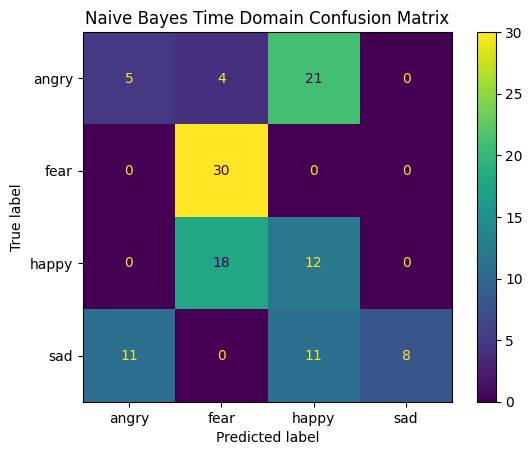

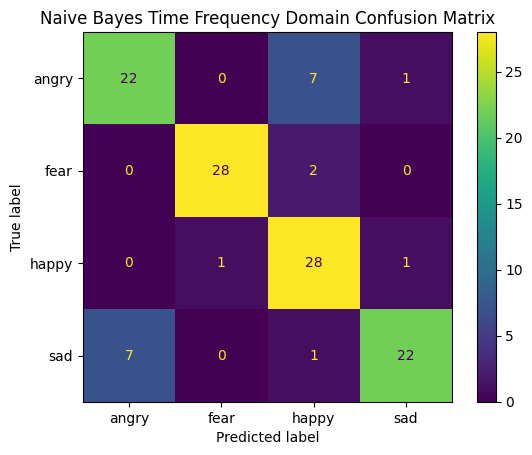

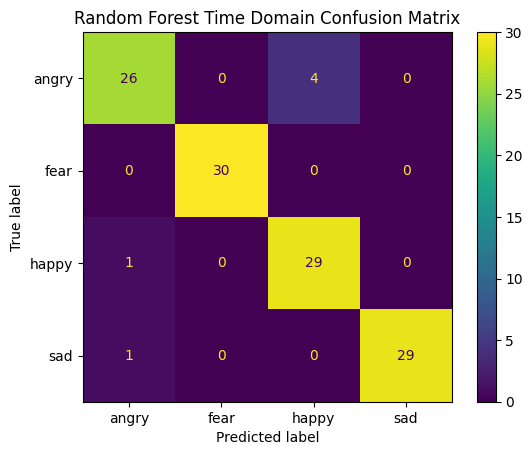

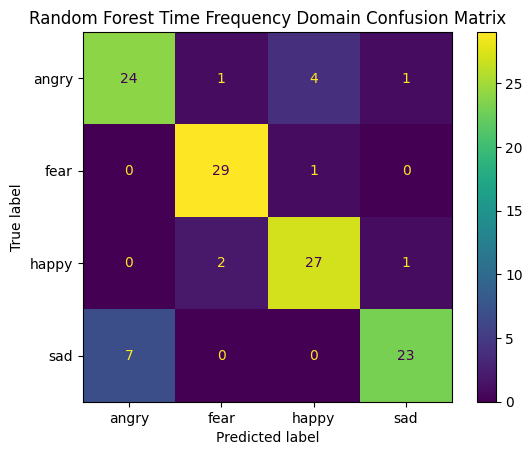

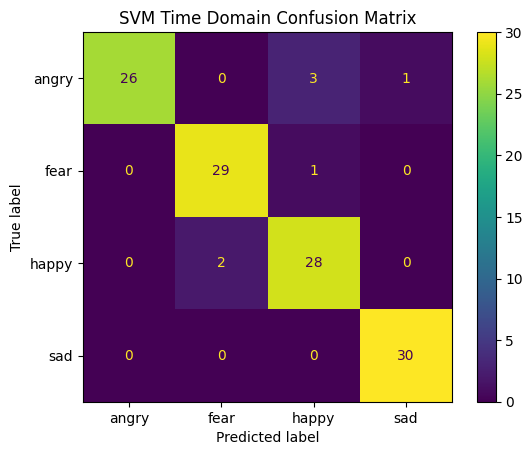

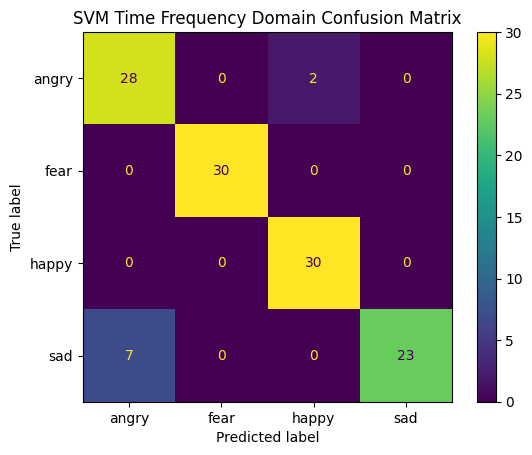

In [45]:
# Plot Confusion Matrices

# Naive Bayes
nb_time_domain_cm = confusion_matrix(y_test, y_nb_time_domain_pred)
nb_time_domain_cm_display = ConfusionMatrixDisplay(nb_time_domain_cm, display_labels=labels)
nb_time_domain_cm_display.plot()
plt.title("Naive Bayes Time Domain Confusion Matrix")
plt.show()

nb_time_frequency_domain_cm = confusion_matrix(y_test, y_nb_time_frequency_domain_pred)
nb_time_frequency_domain_cm_display = ConfusionMatrixDisplay(nb_time_frequency_domain_cm, display_labels=labels)
nb_time_frequency_domain_cm_display.plot()
plt.title("Naive Bayes Time Frequency Domain Confusion Matrix")
plt.show()

# Random Forest

rf_time_domain_cm = confusion_matrix(y_test, y_rf_time_domain_pred)
rf_time_domain_cm_display = ConfusionMatrixDisplay(rf_time_domain_cm, display_labels=labels)
rf_time_domain_cm_display.plot()
plt.title("Random Forest Time Domain Confusion Matrix")
plt.show()

rf_time_frequency_domain_cm = confusion_matrix(y_test, y_rf_time_frequency_domain_pred)
rf_time_frequency_domain_cm_display = ConfusionMatrixDisplay(rf_time_frequency_domain_cm, display_labels=labels)
rf_time_frequency_domain_cm_display.plot()
plt.title("Random Forest Time Frequency Domain Confusion Matrix")
plt.show()

# SVM

svm_time_domain_cm = confusion_matrix(y_test, y_svm_time_domain_pred)
svm_time_domain_cm_display = ConfusionMatrixDisplay(svm_time_domain_cm, display_labels=labels)
svm_time_domain_cm_display.plot()
plt.title("SVM Time Domain Confusion Matrix")
plt.show()

svm_time_frequency_domain_cm = confusion_matrix(y_test, y_svm_time_frequency_domain_pred)
svm_time_frequency_domain_cm_display = ConfusionMatrixDisplay(svm_time_frequency_domain_cm, display_labels=labels)
svm_time_frequency_domain_cm_display.plot()
plt.title("SVM Time Frequency Domain Confusion Matrix")
plt.show()